# Imports :

In [158]:
import numpy as np
import math
import scipy.io
import csv
from IPython.display import display
from scipy import sparse
import os.path
import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from sklearn.feature_extraction.text import CountVectorizer
import re
from collections import Counter
from nltk.corpus import stopwords
import sklearn.neighbors, sklearn.linear_model, sklearn.ensemble, sklearn.naive_bayes
import time
import matplotlib.pyplot as plt
nltk.download("stopwords") 
nltk.download('punkt')
nltk.download('movie_reviews')
#removing stopwords
from nltk import word_tokenize,sent_tokenize

import nltk.classify.util
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import movie_reviews


## drawing tools
# Load libraries

# Math
import numpy as np

# Visualization 
%matplotlib notebook 
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage

# High-res visualization (but no rotation possible)
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png2x','pdf')

# Print output of LFR code
import subprocess

# Sparse matrix
import scipy.sparse
import scipy.sparse.linalg

# 3D visualization
import pylab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot

# Import data
import scipy.io

# Import functions in lib folder
import sys
sys.path.insert(1, 'lib')

# Import helper functions
%load_ext autoreload
%autoreload 2
from lib.utils import compute_ncut
from lib.utils import reindex_W_with_classes
from lib.utils import nldr_visualization
from lib.utils import construct_knn_graph
from lib.utils import compute_purity

# Import distance function
import sklearn.metrics.pairwise

# Remove warnings
import warnings
warnings.filterwarnings("ignore")




def find_between_r( s, first, last ):
    try:
        start = s.rindex( first ) + len( first )
        end = s.rindex( last, start )
        return s[start:end]
    except ValueError:
        return ""

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     C:\Users\pc\AppData\Roaming\nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ImportError: No module named 'ncut'

# Datasets & Preprocessing

** Sentimental Analysis Text dataset: **

In [196]:
SAT_data =[]
with open('Projectdataset/Sentiment Analysis Dataset.csv', 'r') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',')#, quotechar='|')
    for row in spamreader:
        SAT_data.append(row) 
SAT_data = SAT_data[2:]
SAT_data = [[row[1],row[3]] for row in SAT_data]
SAT_data = np.array(SAT_data)
#SAT_data = SAT_data[0:8000]
print('Length = {} '.format(len(SAT_data)))
print('Type = {}'.format(type(SAT_data)))


Length = 1578613 
Type = <class 'numpy.ndarray'>


** Polarity Data: **

In [87]:
polarity_data = []
file1 = open("Projectdataset/rt-polaritydata/rt-polarity.neg", "r")
file2 = open("Projectdataset/rt-polaritydata/rt-polarity.pos", "r")
dataneg = file1.readlines();
datapos = file2.readlines();
dataneg = [i.replace('\n','') for i in dataneg]
datapos = [i.replace('\n','') for i in datapos]

zero = np.zeros(len(dataneg))
dataneg = np.column_stack ((zero , dataneg) )

one = np.ones(len(datapos))
datapos = np.column_stack ((one , datapos) )

polarity_data = np.concatenate ((datapos,dataneg), axis = 0)
np.random.shuffle(polarity_data)

print('Length = {} '.format(len(polarity_data)))
print('Type = {}'.format(type(polarity_data)))
print(polarity_data)

Length = 10662 
Type = <class 'numpy.ndarray'>
[['0.0'
  "personal velocity ought to be exploring these women's inner lives , but it never moves beyond their surfaces . "]
 ['1.0' "there's no reason to miss interview with the assassin"]
 ['0.0'
  "if kaufman kept cameron diaz a prisoner in a cage with her ape , in his latest , he'd have them mate . "]
 ..., 
 ['1.0'
  'lan yu is at times too restrained , yet there are moments it captures the erotics of intimacy in a way that makes most american love stories look downright unfree . ']
 ['0.0'
  "although the sequel has all the outward elements of the original , the first film's lovely flakiness is gone , replaced by the forced funniness found in the dullest kiddie flicks . "]
 ['1.0'
  'mلs sarcلstica , divertida y demencial que su predecesora , es un buen ejemplo de lo que es el cine de entretenimiento puro y sin complejos . ']]


** UMCCompetition: **

In [93]:
umc_data = []
file3 = open("Projectdataset/UMCCompetition/training.txt", "r")
data3 = file3.readlines()
for i in range(0,len(data3)):
    data3[i] = data3[i].replace('\n','')
    data3[i] = data3[i].split("\t")
umc_data = np.asarray(data3)
np.random.shuffle(umc_data)
print('Length = {} '.format(len(umc_data)))
print('Type = {}'.format(type(umc_data)))
print(umc_data)

Length = 1509 
Type = <class 'numpy.ndarray'>
[['1' 'i thought da vinci code was great, same with kite runner.']
 ['1' 'Mission Impossible III was SO awesome!..']
 ['1'
  'The Da Vinci Code was so awesome, I cannot even begin to comprehend nor explain the awesomeness of its hardcore, awesome power of awesomeness.....']
 ..., 
 ['1'
  'i love kirsten / leah / kate escapades and mission impossible tom as well...']
 ['1' 'The Da Vinci Code is awesome!!']
 ['1' "The Da Vinci Code was awesome, I can't wait to read it..."]]


** Amazon dataset: **

In [128]:
Amazon_data = []
file4 = open("Projectdataset/amazonMP3reviews/amazon_mp3", "r")
data4 = file4.read()

data4 = data4.split("#####")
for i in range(1,len(data4)):
    text = find_between_r( data4[i], "[fullText]:", "[rating]" )
    text = text.replace("\n",'')
    rating = find_between_r( data4[i],"[rating]:","[recommend]")
    Amazon_data.append([float(rating),text])
Amazon_data = np.asarray(Amazon_data)
Amazon_data = Amazon_data[0:8000]
print('Length = {} '.format(len(Amazon_data)))
print('Type = {}'.format(type(Amazon_data)))
print(Amazon_data)


Length = 8000 
Type = <class 'numpy.ndarray'>
[['2.0'
  "It is good if you have internet than you can download the stuff, else, you can't  "]
 ['5.0'
  "The RIO rocks! It is so great that Diamond Multimedia prevailed in their fight against the forces of pure evil in the music industry and allowed us, the public, to have the RIO! This little baby holds your MP3's and plays  them with outrageous quality and no moving parts! You simply cannot make  the music &quot;skip&quot;. Take it jogging, bob sledding, whatever! The  Rio is cute and compact, battery lasts forever, runs great and is really  simple to use. Works well with the PC linkup, etc. A hot item!  "]
 ['4.0'
  'I had high hopes for the Diamond Rio and it certainly lived up 2 the hype. Lightweight and excellent quality with some good connecting software. My only gripe can be with memory. You definately need another 32Mb to store  your music. If you want one, my advice is to wait for the new upgraded  version with 64Mb and a graphi

** TripAdvisor dataset **

In [149]:
tripAdvisor_data1 = []
path = 'Projectdataset/tripadvisor/Aspects'
dirs = os.listdir(path)


for direct in dirs:
    #print(direct)
    file5 = open(path+'/'+direct, "r")
    data5 = file5.read()
    data5 = data5.split("<Author>")
    data5 = data5[1:]
    for data in data5:
        ignore = False;
        text = find_between_r( data, "<Content>", "<Date>")
        text = text.replace("\n",'')
        rank = find_between_r( data, "<Rating>", "<Aspects>")
        rank = rank.rstrip().split('\t') 
        if (rank ==['']):
                ignore = True
        if not (ignore): 
            rank = [float(x) for x in rank]
            rank =round(np.mean(rank))
            tripAdvisor_data1.append((rank, text))
       
        
tripAdvisor_data2 = []
path2 = 'Projectdataset/tripadvisor/Texts'
dirs2 = os.listdir(path2)


#for direct in dirs2:
    #print(direct)
    #file6 = open(path2+'/'+direct, "r")
    #data6 = file6.readlines()
    #for data in data6:
        #ignore = False;
        #if "<Content>" in data:
            #text = data.split(">")[1]
            #text = text.replace("\n",'')
        #if "<Rating>" in data:
         #   rank = data.split(">")[1]
         #   rank = rank.rstrip().split('\t') 
         #   if (rank ==['']):
         #       ignore = True
         #   if not(ignore):       
         #       rank = [float(x) for x in rank]
         #       rank = np.mean(rank)
         #       tripAdvisor_data2.append((rank, text))
            


In [150]:
tripAdvisor_data1=np.asarray(tripAdvisor_data1[0:9000])
print('Length = {} '.format(len(tripAdvisor_data1)))
print('Type = {}'.format(type(tripAdvisor_data1)))

tripAdvisor_data2=tripAdvisor_data2[0:8000]
print('Length = {} '.format(len(tripAdvisor_data2)))
print('Type = {}'.format(type(tripAdvisor_data2)))
#print(tripAdvisor_data2[1])

Length = 9000 
Type = <class 'numpy.ndarray'>
4.0
Length = 0 
Type = <class 'list'>


** Sorted Data ACL **

In [107]:
#################################### Books ######################################################
books_data = []
file7 = open('Projectdataset/sorted_data_acl/books/negative.review', "r")
file8 = open('Projectdataset/sorted_data_acl/books/positive.review', "r")

negative = file7.read()
positive = file8.read()
######## books
negative = negative.split("<review>")
positive = positive.split("<review>")
negative = negative[1:]
positive = positive[1:]

a = []
b = []
for neg in negative:
    text = find_between_r( neg, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( neg, "<rating>", "</rating>")
    a.append((rate,text))
    
for pos in positive:
    text = find_between_r( pos, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( pos, "<rating>", "</rating>")
    b.append((rate,text))

books_data = np.concatenate((a,b) , axis = 0)
np.random.shuffle(books_data)
print("books review")
print('Length = {} '.format(len(books_data)))
print('Type = {}'.format(type(books_data)))
#print(books_data)

#################################### DVDs ######################################################
DVD_dataset= []
file9 = open('Projectdataset/sorted_data_acl/dvd/negative.review', "r")
file10 = open('Projectdataset/sorted_data_acl/dvd/positive.review', "r")
negative = file9.read()
positive = file10.read()

negative = negative.split("<review>")
positive = positive.split("<review>")
negative = negative[1:]
positive = positive[1:]

a = []
b = []
for neg in negative:
    text = find_between_r( neg, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( neg, "<rating>", "</rating>")
    a.append((rate,text))
    
for pos in positive:
    text = find_between_r( pos, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( pos, "<rating>", "</rating>")
    b.append((rate,text))


DVD_dataset = np.concatenate((a,b) , axis = 0)
np.random.shuffle(DVD_dataset)
print("dvds_review")
print('Length = {} '.format(len(DVD_dataset)))
print('Type = {}'.format(type(DVD_dataset)))
#print(DVD_dataset)

#################################### Electronics ######################################################
electronics_data = []
file11 = open('Projectdataset/sorted_data_acl/electronics/negative.review', "r")
file12 = open('Projectdataset/sorted_data_acl/electronics/positive.review', "r")

negative = file11.read()
positive = file12.read()

negative = negative.split("<review>")
positive = positive.split("<review>")
negative = negative[1:]
positive = positive[1:]

a = []
b = []
for neg in negative:
    text = find_between_r( neg, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( neg, "<rating>", "</rating>")
    a.append((rate,text))
    
for pos in positive:
    text = find_between_r( pos, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( pos, "<rating>", "</rating>")
    b.append((rate,text))

electronics_data = np.concatenate((a,b) , axis = 0)
np.random.shuffle(electronics_data)
print("electronics_review")
print('Length = {} '.format(len(electronics_data)))
print('Type = {}'.format(type(electronics_data)))
#print(electronics_data)
########################################## kitchen_&_housewares ##############################################
kh_dataset = []
file13 = open('Projectdataset/sorted_data_acl/kitchen_&_housewares/negative.review', "r")
file14 = open('Projectdataset/sorted_data_acl/kitchen_&_housewares/positive.review', "r")

negative = file13.read()
positive = file14.read()

negative = negative.split("<review>")
positive = positive.split("<review>")
negative = negative[1:]
positive = positive[1:]

a = []
b = []
for neg in negative:
    text = find_between_r( neg, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( neg, "<rating>", "</rating>")
    a.append((rate,text))
    
for pos in positive:
    text = find_between_r( pos, "<review_text>", "</review_text>")
    text = text.replace("\n",'')
    rate = find_between_r( pos, "<rating>", "</rating>")
    b.append((rate,text))

kh_dataset = np.concatenate((a,b) , axis = 0)
np.random.shuffle(kh_dataset)
print("kh_review")
print('Length = {} '.format(len(kh_dataset)))
print('Type = {}'.format(type(kh_dataset)))

review_data = np.concatenate((books_data,DVD_dataset,electronics_data,kh_dataset))
np.random.shuffle(review_data)
print("review_data")
print('Length = {} '.format(len(review_data)))
print('Type = {}'.format(type(review_data)))
print(review_data)

books review
Length = 2000 
Type = <class 'numpy.ndarray'>
dvds_review
Length = 2000 
Type = <class 'numpy.ndarray'>
electronics_review
Length = 2000 
Type = <class 'numpy.ndarray'>
kh_review
Length = 2000 
Type = <class 'numpy.ndarray'>
review_data
Length = 8000 
Type = <class 'numpy.ndarray'>
[['\n4.0\n'
  "An absolutely wonderful film by Clint Eastwood. Thelonious was an amazing man. He said things on the piano that we wordsmiths aren't able to communicate. His unusual character made for an interesting subplot. This film is footage of the man himself, usually playing his music. I'm just sitting here being stunned."]
 ['\n5.0\n'
  "Many shows have their moments, but this is the first show I've ever laughed OUT LOUD, multiple times in one episode.  The humor is so creative and edgy and amazingly timed.  I will say that you do need to be around my age (I'm 40) to get alot of the inside jokes, but if you do their hilarious.  And if you don't there's still plenty to make you laugh.  I wo

** Combine data **

# Binary Classification
** feature extraction **

In [57]:
def word_feats(words):
        return dict([(word, True) for word in words])
    
negids = movie_reviews.fileids('neg')
posids = movie_reviews.fileids('pos')
 
negfeats = [(word_feats(movie_reviews.words(fileids=[f])), 'neg') for f in negids]
posfeats = [(word_feats(movie_reviews.words(fileids=[f])), 'pos') for f in posids]

negcutoff = int(len(negfeats)*3/4)
poscutoff = int(len(posfeats)*3/4)

trainfeats = negfeats[:negcutoff] + posfeats[:poscutoff]
testfeats = negfeats[negcutoff:] + posfeats[poscutoff:]
print('train on %d instances, test on %d instances' % (len(trainfeats), len(testfeats)))
 
classifier = NaiveBayesClassifier.train(trainfeats)
print('accuracy:', nltk.classify.util.accuracy(classifier, testfeats))
classifier.show_most_informative_features()

train on 1500 instances, test on 500 instances
accuracy: 0.728
Most Informative Features
             magnificent = True              pos : neg    =     15.0 : 1.0
             outstanding = True              pos : neg    =     13.6 : 1.0
               insulting = True              neg : pos    =     13.0 : 1.0
              vulnerable = True              pos : neg    =     12.3 : 1.0
               ludicrous = True              neg : pos    =     11.8 : 1.0
                  avoids = True              pos : neg    =     11.7 : 1.0
             uninvolving = True              neg : pos    =     11.7 : 1.0
             fascination = True              pos : neg    =     10.3 : 1.0
              astounding = True              pos : neg    =     10.3 : 1.0
                 idiotic = True              neg : pos    =      9.8 : 1.0


AttributeError: 'NaiveBayesClassifier' object has no attribute 'predict'

# Feature Extraction
** Bag of Words Feature Extraction ** 






In [151]:
def column(matrix, i):
    return [row[i] for row in matrix]
def compute_bag_of_words(text, nwords):
    vectorizer = CountVectorizer(max_features=nwords)
    vectors = vectorizer.fit_transform(text)
    vocabulary = vectorizer.get_feature_names()
    return vectors, vocabulary

nwords = 300 # number of words to represent text

# all datasets texts
text_polarity = column(polarity_data,1)
text_amazon = column(Amazon_data,1)
text_sat = column(SAT_data,1)
text_trip = column(tripAdvisor_data1,1)
text_items = column(review_data,1)
# all datasets ratings
Y_polarity = np.asarray(column(polarity_data,0))
Y_amazon = np.asarray(column(Amazon_data,0))
Y_sat = np.asarray(column(SAT_data,0))
Y_trip = np.asarray(column(tripAdvisor_data1,0))
Y_items = np.asarray(column(review_data,0))

names = ["Polarity Dataset","Amazon Dataset","SAT dataset","Trip Advisor","Items"]
texts = [text_polarity,text_amazon,text_sat,text_trip,text_items]
Ys = [Y_polarity , Y_amazon, Y_sat, Y_trip, Y_items]
stop_words = set(stopwords.words('english'))

filtered_data =[]
bows = []
i = 0

for textset in texts:
    filtered=[];
    for item in textset:
        words = word_tokenize(item)
        words =[word.lower() for word in words]
        filtered_item=[];
        for w in words:
            if w not in stop_words:
                filtered_item.append(w)
        result = ' '.join(filtered_item)
        filtered.append(result)
    bow, vocab = compute_bag_of_words(filtered, nwords)
    bows.append(bow)
    print("Dataset ={}".format(names[i]))
    print("Length = {}".format(len(filtered))) 
    print("bow = {}".format(bow.shape))
    print("Y = {}".format(Ys[i].shape))
    filtered_data.append(filtered)
    i += 1


Dataset =Polarity Dataset
Length = 10662
bow = (10662, 300)
Y = (10662,)
Dataset =Amazon Dataset
Length = 8000
bow = (8000, 300)
Y = (8000,)
Dataset =SAT dataset
Length = 8000
bow = (8000, 300)
Y = (8000,)
Dataset =Trip Advisor
Length = 9000
bow = (9000, 300)
Y = (9000,)
Dataset =Items
Length = 8000
bow = (8000, 300)
Y = (8000,)


# Dividing into Training data and Testing data

In [152]:
#####polarity


X_trains = []
X_tests = []
Y_trains = []
Y_tests = []
i = 0
for textset in texts:
    cutoff = math.ceil(len(Ys[i])*0.75)
    print(cutoff)
    X_trains.append(bows[i][0:cutoff])
    X_tests.append(bows[i][cutoff:])
    Y_trains.append(Ys[i][0:cutoff])
    Y_tests.append(Ys[i][cutoff:])
    #display("X_train: {}".format(X_trains[i].shape))
    #display("X_test: {}".format(X_tests[i].shape))
    #display("Y_train: {}".format(Y_trains[i].shape))
    #display("Y_test: {}".format(Y_tests[i].shape))
    #display(type(X_tests[i]))
    #display(type(Y_trains[i]))
    #display((X_tests[i]))
    #display((Y_trains[i]))
    i+=1


7997
6000
6000
6750
6000


# Classifiers and using the right one

In [153]:

# The different classifiers
clf, train_accuracy, test_accuracy, exec_time = [], [], [], []
clf.append(sklearn.neighbors.KNeighborsClassifier()) # k-NN classifier
clf.append(sklearn.svm.LinearSVC()) # linear SVM classifier
clf.append(sklearn.linear_model.LogisticRegression()) # logistic classifier
clf.append(sklearn.ensemble.RandomForestClassifier())
clf.append(sklearn.linear_model.RidgeClassifier())
clf.append(sklearn.naive_bayes.BernoulliNB())
clf.append(sklearn.naive_bayes.MultinomialNB())


train_accuracies = []
test_accuracies = []


# train on different datasets 
for i in range (0,len(names)):
    print("Dataset = {}".format(names[i]))
    classifier = ['KNN','SVM','Log-R','RanF', 'RC','B','MultiNB']
    j = 0
    train_accuracy = []
    test_accuracy = []
    for c in clf:
        #t_start = time.process_time()
        c.fit(X_trains[i], Y_trains[i])
        train_pred = c.predict(X_trains[i])
        test_pred = c.predict(X_tests[i])
        train_accuracy .append( '{:5.2f}'.format(100*sklearn.metrics.accuracy_score(Y_trains[i], train_pred)) )
        test_accuracy .append( '{:5.2f}'.format(100*sklearn.metrics.accuracy_score(Y_tests[i], test_pred)) )
        #exec_time.append('{:5.2f}'.format(time.process_time() - t_start))
        print('Classifier:          {}'.format(classifier[j]))
        print('Train accuracy:      {}'.format(train_accuracy[j]))
        print('Test accuracy:       {}'.format(test_accuracy[j]))
        j+=1
        #print('Execution time:      {}'.format(exec_time))
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

Dataset = Polarity Dataset
Classifier:          K-nn
Train accuracy:      70.70
Test accuracy:       55.68
Classifier:          SVM
Train accuracy:      68.06
Test accuracy:       66.00
Classifier:          linear Regression
Train accuracy:      68.16
Test accuracy:       66.00
Classifier:          Random Forest
Train accuracy:      91.78
Test accuracy:       60.38
Classifier:          RidgeClassifier
Train accuracy:      68.19
Test accuracy:       65.85
Classifier:          Bernoulli
Train accuracy:      67.84
Test accuracy:       64.99
Classifier:          MultiNB
Train accuracy:      67.81
Test accuracy:       64.95
Dataset = Amazon Dataset
Classifier:          K-nn
Train accuracy:      60.75
Test accuracy:       42.90
Classifier:          SVM
Train accuracy:      60.27
Test accuracy:       54.90
Classifier:          linear Regression
Train accuracy:      60.85
Test accuracy:       54.20
Classifier:          Random Forest
Train accuracy:      99.15
Test accuracy:       45.60
Classif

'Dataset: Polarity Dataset '

'best test accuracy = 66.00  for = SVM'

'Dataset: Amazon Dataset '

'best test accuracy = 54.90  for = SVM'

'Dataset: SAT dataset '

'best test accuracy = 70.10  for = MultiNB'

'Dataset: Trip Advisor '

'best test accuracy = 28.40  for = RC'

'Dataset: Items '

'best test accuracy = 52.20  for = SVM'

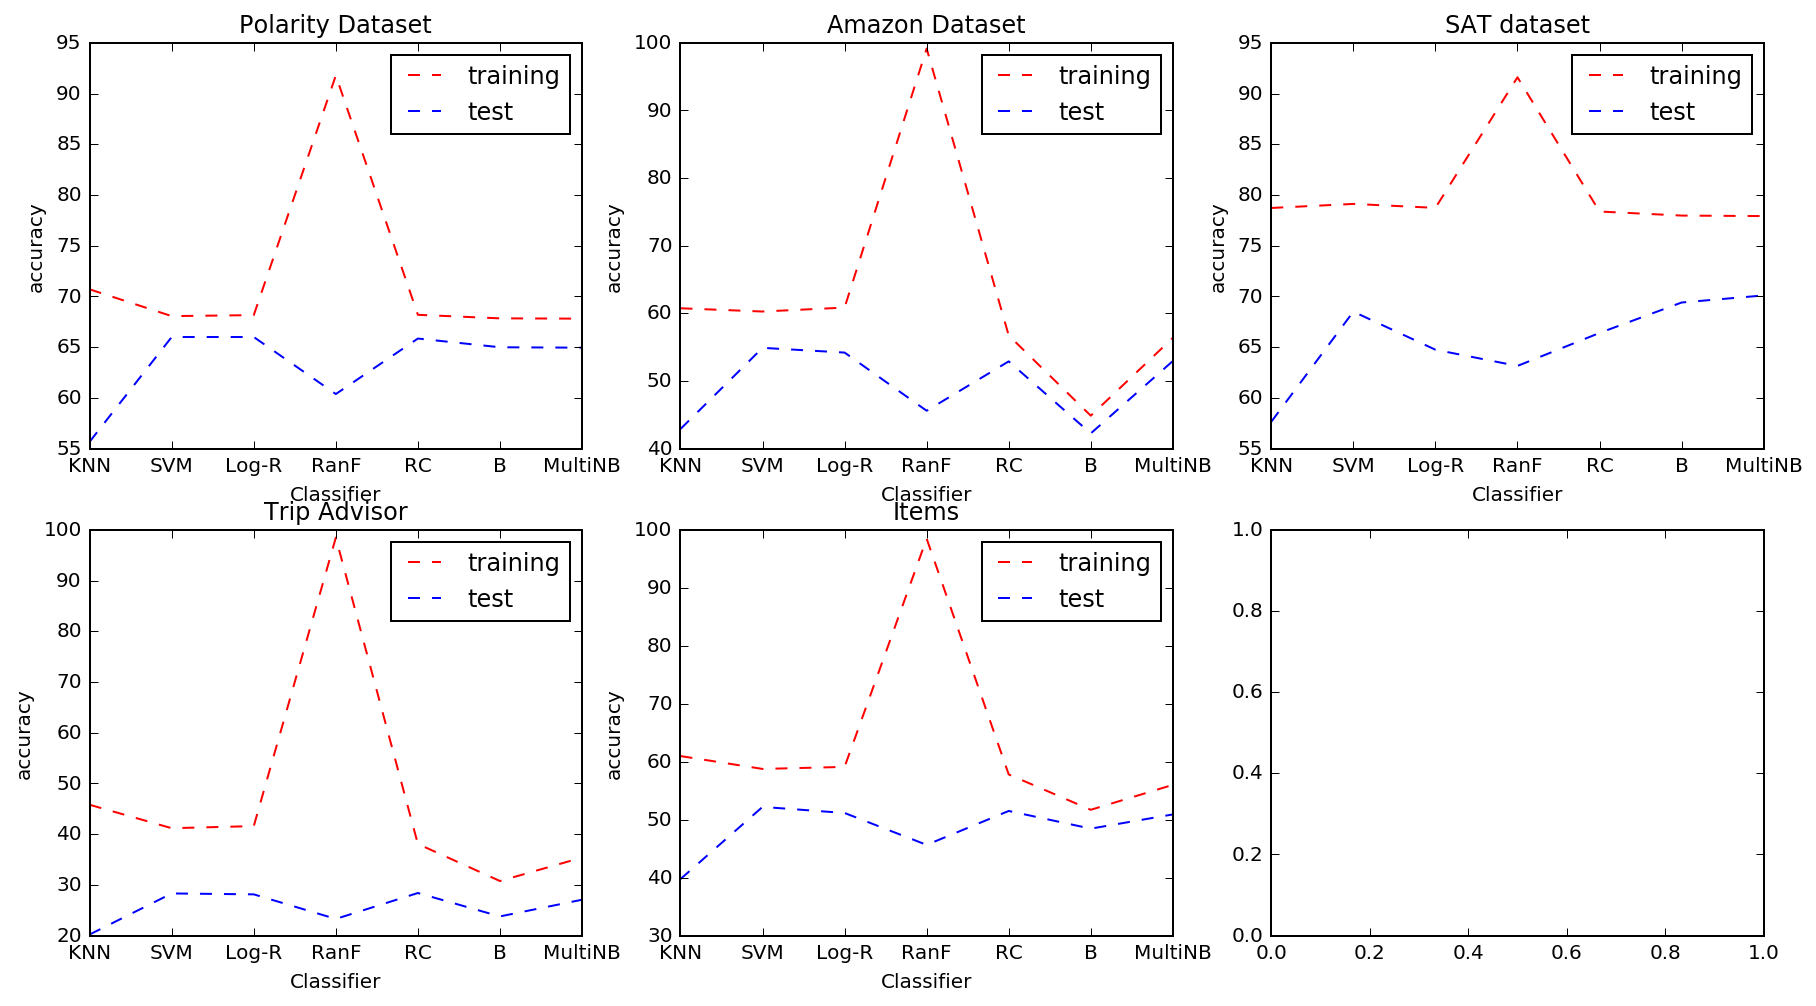

In [195]:
x =[0,1,2,3,4,5,6]
classifier = ['KNN','SVM','Log-R','RanF', 'RC','B','MultiNB']
Leg = ["training","test"]
n = 5
fig, axes = plt.subplots(2, 3, squeeze=True, figsize=(15, 8))
for i in range(n):
    axes[i//3,i%3].set_xticks(x)
    axes[i//3,i%3].set_xticklabels(classifier, fontdict=None, minor=False)
    axes[i//3,i%3].plot(x,train_accuracies[i],"r--",x,test_accuracies[i],"b--")
    axes[i//3,i%3].set_title(names[i])
    axes[i//3,i%3].set_ylabel("accuracy")
    axes[i//3,i%3].set_xlabel("Classifier")
    axes[i//3,i%3].legend(Leg)

for i in range(n):  
    display("Dataset: {} ".format(names[i]))
    value = max(test_accuracies[i])
    index = test_accuracies[i].index(value)
    display("best test accuracy = {}  for = {}".format(value,classifier[index]))
    
    
#plt.xticks(x,classifier)#,names,knn_test,"b--")
#plt.plot(x,train_accuracies[0],"r--",x,test_accuracies[0],"b--")



#plt.show()

** N-FOLDS **

In [46]:
num_folds = 5 
X_train = X_train.toarray() # for np.array_split

X_train_folds = np.array_split(X_train, num_folds)
y_train_folds = np.array_split(Y_train, num_folds)

#print(X_train_folds[0][1])

C_choices = [1e-2, 5*1e-2,1e-2, 5*1e-2, 1e-1, 5*1e-1, 1e0, 5*1e0, 1e1, 5*1e1, 1e2, 5*1e2, 1e3, 5*1e3]
num_Cs = len(C_choices)

accuracy_tab = np.zeros([num_folds,num_Cs])
for C_idx, C_value in enumerate(C_choices):

    for fold_idx in range(num_folds):
        
        # Extract train dataset for the current fold
        fold_x_train = np.concatenate([X_train_folds[i] for i in range(num_folds) if i!=fold_idx])       
        fold_y_train = np.concatenate([y_train_folds[i] for i in range(num_folds) if i!=fold_idx])   

        # validation dataset for the current fold
        fold_x_val  = X_train_folds[fold_idx]
        fold_y_val  = y_train_folds[fold_idx]
        
        # Run Logistic Regression model for the current fold
        model = sklearn.svm.LinearSVC(C=C_value)
        model.fit(fold_x_train, fold_y_train)
        test_pred = model.predict(fold_x_val)
        accuracy = sklearn.metrics.accuracy_score(test_pred, fold_y_val)
        
        # Store accuracy value
        accuracy_tab[fold_idx,C_idx] = accuracy

print(accuracy_tab)

[[ 0.53444444  0.535       0.53444444  0.535       0.53611111  0.53055556
   0.54        0.53277778  0.52888889  0.47555556  0.43722222  0.43833333
   0.445       0.35222222]
 [ 0.56055556  0.55777778  0.56055556  0.55777778  0.55833333  0.56
   0.55833333  0.54833333  0.54555556  0.44722222  0.48833333  0.40166667
   0.49166667  0.43944444]
 [ 0.55333333  0.55        0.55333333  0.55        0.55111111  0.55222222
   0.55444444  0.54611111  0.53611111  0.49944444  0.46166667  0.37166667
   0.45722222  0.43388889]
 [ 0.56277778  0.56055556  0.56277778  0.56055556  0.56        0.55888889
   0.56        0.54833333  0.55277778  0.51944444  0.50111111  0.40222222
   0.43333333  0.39611111]
 [ 0.53444444  0.53333333  0.53444444  0.53444444  0.53388889  0.53888889
   0.53388889  0.52111111  0.515       0.44833333  0.42333333  0.35444444
   0.45        0.41944444]]


In [33]:
# plot the raw observations
for C_idx, C_value in enumerate(C_choices):
    accuracies_C_idx = accuracy_tab[:,C_idx]
    plt.scatter([np.log(C_value)]* len(accuracies_C_idx), accuracies_C_idx)
    
# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.mean(accuracy_tab,axis=0)
accuracies_std = np.std(accuracy_tab,axis=0)
plt.errorbar(np.log(C_choices), accuracies_mean, yerr=accuracies_std)

# Add text
plt.title('Cross-validation on C')
plt.xlabel('log C')
plt.ylabel('Cross-validation accuracy')

plt.show()

In [47]:
idx_best_C = np.argmax(accuracies_mean)
best_C = C_choices[idx_best_C]
model = sklearn.linear_model.LogisticRegression(C=best_C)
model.fit(X_train, Y_train)
test_pred = model.predict(X_test)
accuracy_testset = sklearn.metrics.accuracy_score(test_pred, Y_test)
print('best accuracy=',accuracy_testset)
print('best C =',best_C)

best accuracy= 0.557333333333
best C = 0.1


# Classifiers and using the right one

ValueError: kd_tree does not work with sparse matrices. Densify the data, or set algorithm='brute'